In [1]:
!cp ../input/gdcm-conda-install/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2

gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | / done
Executing transaction: \ done


In [2]:
!pip install ../input/efficientnet-pytorch063/efficientnet_pytorch-0.6.3-py3-none-any.whl

Processing /kaggle/input/efficientnet-pytorch063/efficientnet_pytorch-0.6.3-py3-none-any.whl


In [3]:
!pip install -q ../input/noamior/monai-0.3.0-202010042353-py3-none-any.whl

In [4]:
import gdcm
from efficientnet_pytorch import EfficientNet
import efficientnet_pytorch
import torch
efficientnet_pytorch.__version__

'0.6.3'

In [5]:
def load_cnn(filepath,name):
    cnn5 = EfficientNet.from_name(name).cuda()
    if name == 'efficientnet-b5':
        cnn5._fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
    elif name == 'efficientnet-b4':
        cnn5._fc = torch.nn.Linear(in_features=1536+256, out_features=1, bias=True)
    elif name == 'efficientnet-b3':
        cnn5._fc = torch.nn.Linear(in_features=1536, out_features=1, bias=True)
    elif name == 'efficientnet-b2':
        cnn5._fc = torch.nn.Linear(in_features=1408, out_features=1, bias=True)
    cnn5 = torch.nn.DataParallel(cnn5)
    cnn5.load_state_dict(torch.load(filepath))
    cnn5.eval()
    return cnn5

In [6]:
import os
os.listdir('../input/rsnalstm2/')

['efficientnet-b5_cnn_4_best.pth',
 'efficientnet-b4_cnn_4_best.pth',
 'efficientnet-b3_cnn_2_last.pth',
 'efficientnet-b5_cnn_1_best.pth',
 'efficientnet-b5_cnn_3_best.pth',
 'efficientnet-b4_cnn_1_best.pth',
 'efficientnet-b3_cnn_1_best.pth',
 'efficientnet-b2_cnn_2_best.pth',
 'efficientnet-b3_cnn_0_best.pth',
 'efficientnet-b2_cnn_3_best.pth',
 'efficientnet-b4_cnn_3_best.pth',
 'lstm_pe_neg43_best.pth',
 'efficientnet-b3_cnn_4_best.pth',
 'efficientnet-b3_cnn_2_best.pth',
 'efficientnet-b2_cnn_1_best.pth',
 'efficientnet-b5_cnn_2_best.pth',
 'efficientnet-b2_cnn_0_best.pth',
 'efficientnet-b4_cnn_2_best.pth',
 'efficientnet-b4_cnn_0_best.pth',
 'efficientnet-b2_cnn_4_best.pth',
 'efficientnet-b3_cnn_3_best.pth',
 'lstm1_val_best.pth',
 'efficientnet-b5_cnn_0_best.pth']

In [7]:
cnnb3 = [load_cnn(f'../input/rsnalstm2/efficientnet-b3_cnn_{row}_best.pth','efficientnet-b3') for row in [2,3]]
cnnb4 = [load_cnn(f'../input/rsnalstm2/efficientnet-b4_cnn_{row}_best.pth','efficientnet-b4') for row in [2,4]]
cnnb5 = [load_cnn(f'../input/rsnalstm2/efficientnet-b5_cnn_{row}_best.pth','efficientnet-b5') for row in [1,3]]

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import cv2
import os
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader,Dataset
import albumentations as albu
import functools
import torch
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from joblib import parallel_backend

In [9]:
test_csv_path = '../input/rsna-str-pulmonary-embolism-detection/test.csv'

In [10]:
df = pd.read_csv(test_csv_path)
df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID
0,df06fad17bc3,857e3d760445,c3163725fcf6
1,df06fad17bc3,857e3d760445,d54a8daaf836
2,df06fad17bc3,857e3d760445,bdc531b699cd
3,df06fad17bc3,857e3d760445,9e6a68e27df0
4,df06fad17bc3,857e3d760445,25e3307ba7da


In [11]:
import pydicom
import cv2
import os, os.path as osp

from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def pixel_array(d):
    return d.pixel_array
def load_dicom_array(f):
    dicom_files = glob.glob(osp.join(f, '*.dcm'))
    dicoms = [pydicom.dcmread(d) for d in dicom_files]
    M = float(dicoms[0].RescaleSlope)
    B = float(dicoms[0].RescaleIntercept)
    z_pos = [float(d.ImagePositionPatient[-1]) for d in dicoms]
    dicoms = np.asarray([d.pixel_array for d in dicoms])
    dicoms = dicoms[np.argsort(z_pos)]
    dicoms = dicoms * M
    dicoms = dicoms + B
    return dicoms, np.asarray(dicom_files)[np.argsort(z_pos)]


def window(img, WL=50, WW=350):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / np.max(X)
    X = (X*255.0).astype('uint8')
    return X


def save_array(X, save_dir, file_names):
    for ind, img in enumerate(X):
        savefile = osp.join(save_dir, file_names[ind])
        if not osp.exists(osp.dirname(savefile)): 
            os.makedirs(osp.dirname(savefile))
        _ = cv2.imwrite(osp.join(save_dir, file_names[ind]), img)


def edit_filenames(files):
    dicoms = [f"{ind:04d}_{f.split('/')[-1].replace('dcm','jpg')}" for ind,f in enumerate(files)]
    series = ['/'.join(f.split('/')[-3:-1]) for f in files]
    return [osp.join(s,d) for s,d in zip(series, dicoms)]

In [12]:
class config:
    model_name="b5"
    batch_size = 1
    WORKERS = 0
    classes =14
    resume = False
    epochs = 1
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [13]:
def get_training_augmentation(y=256,x=256):
    train_transform = [albu.RandomBrightnessContrast(p=0.3),
                           albu.VerticalFlip(p=0.5),
                           albu.HorizontalFlip(p=0.5),
                           albu.Downscale(p=1.0,scale_min=0.35,scale_max=0.75,),
                           albu.Resize(y, x)]
    return albu.Compose(train_transform)


formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}
def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

#     if mean is not None:
#         mean = np.array(mean)
#         x = x - mean

#     if std is not None:
#         std = np.array(std)
#         x = x / std

    return x

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_validation_augmentation(y=224,x=224):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.Resize(256, 256),albu.CenterCrop(y,x)]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def norm(img):
    img-=img.min()
    return img/img.max()

import monai
from monai.transforms import LoadNifti, Randomizable, apply_transform
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor
from monai.utils import get_seed
import time
class Lungs(Dataset, Randomizable):
    def __init__(self, dicom_folders):
        self.dicom_folders = dicom_folders
        self.transforms = get_validation_augmentation()
        self.preprocessing = get_preprocessing(functools.partial(preprocess_input, **formatted_settings))
        self.transform3d = Compose([ScaleIntensity(), Resize((160, 160, 160)), ToTensor()])
    def __len__(self): 
        return len(self.dicom_folders)
    
    def randomize(self) -> None:
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self._seed = self.R.randint(MAX_SEED, dtype="uint32") 
        
    def get(self, i):
        s = time.time()
        data = load_dicom_array(self.dicom_folders[i])
        image, files = data
        image_lung = np.expand_dims(window(image, WL=-600, WW=1500), axis=3)
        image_mediastinal = np.expand_dims(window(image, WL=40, WW=400), axis=3)
        image_pe_specific = np.expand_dims(window(image, WL=100, WW=700), axis=3)
        image = np.concatenate([image_mediastinal, image_pe_specific, image_lung], axis=3)
        rat = MAX_LENGTH / np.max(image.shape[1:])
        names = [row.split(".dcm")[0].split("/")[-3:] for row in files]
        images = []
        for img in image:
            if self.transforms:
                img = self.transforms(image=img)['image']
            if self.preprocessing:
                img = self.preprocessing(image=img)['image']
            images.append(img)
        images = np.array(images)
        img = images[:,::-1].transpose(1,2,3,0)
        if self.transform3d is not None:
            if isinstance(self.transform3d, Randomizable):
                self.transform3d.set_random_state(seed=self._seed)
            img = apply_transform(self.transform3d, img)
            
        return torch.from_numpy(images),names,img
    
    def __getitem__(self, i):
        self.randomize()
        try:
            return self.get(i)
        except Exception as e:
            print(e)
            return None,None

MAX_LENGTH = 256.

dicom_folders = list(('../input/rsna-str-pulmonary-embolism-detection/test/' + df.StudyInstanceUID + '/'+ df.SeriesInstanceUID).unique())
dset = Lungs(dicom_folders)

In [14]:
test = DataLoader(dset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS)

In [15]:
x,n,x1 = dset[0]

torch.Size([3, 160, 160, 160])


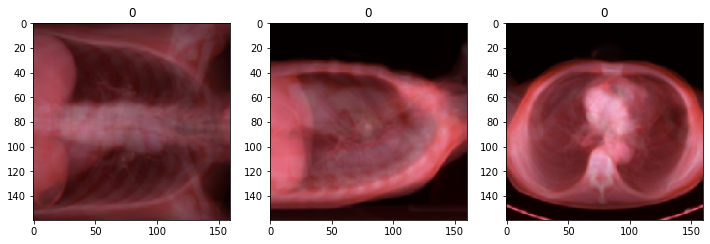

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
for i in range(1):
    f, axarr = plt.subplots(1,3)
    _,_,img = dset[i]
    print(img.shape)
    for j in range(3):            
        axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))        
        axarr[j].set_title(i)
    plt.show()

In [17]:
classes = list(pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/train.csv").columns[3:])

In [18]:
sub = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/sample_submission.csv")
sub.id = sub.id.astype(str)

In [19]:
do_all = len(os.listdir("../input/rsna-str-pulmonary-embolism-detection/test/"))>700
# do_all=True

In [20]:
from torch import nn
from torch.nn import functional as F
import torch

sigmoid = nn.Sigmoid()



class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)
    
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).cuda().float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

class NeuralNet2(nn.Module):
    def __init__(self, embed_size=5379, LSTM_UNITS=512, DO = 0.2,g=0.05):
        super(NeuralNet2, self).__init__()
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True,dropout=0.0)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True,dropout=0.0)
        self.Noise = GaussianNoise(g)
        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.avd3d = nn.AdaptiveAvgPool3d(1)
        self.avd1d = nn.AdaptiveAvgPool1d(1)
        
        self.linear_rv = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear_rlc = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear_pe = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        
        self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global_fc0 = nn.Linear(3073, 3) #ALL_PE,NEG,IND
        self.linear_global_fc1 = nn.Linear(LSTM_UNITS*2*2, 3) #RV>1,RV<1,Not PE
        self.linear_global_fc2 = nn.Linear(3073, 4) #Chronic, Chronic+Acute, Not PE,Acute
        self.linear_global_fc3 = nn.Linear(LSTM_UNITS*2*2, 3) #right,left,center
        self.dropuot3d = nn.Dropout3d(DO)
        self.dropuot1d = nn.Dropout(DO)
        self.s3d = Swish_Module()
        self.s1d = Swish_Module()
        self.s2d = Swish_Module()
        
        
    def forward(self, x, x_rv,x_rlc,x_pe):
        
        x_rv = self.dropuot3d(x_rv)
        x_rv = self.avd3d(x_rv).reshape(1,-1)
        x_rv1 = self.s3d(self.linear_rv(x_rv))
        x_rv = x_rv.reshape(1,-1)
        x_rv1 = x_rv1.reshape(1,-1)
        
        
        x_rlc = self.dropuot3d(x_rlc)
        x_rlc = self.avd3d(x_rlc).reshape(1,-1)
        x_rlc1 = self.s3d(self.linear_rlc(x_rlc))
        x_rlc = x_rlc.reshape(1,-1)
        x_rlc1 = x_rlc1.reshape(1,-1)
        
        
        x_pe = self.dropuot3d(x_pe)
        x_pe = self.avd3d(x_pe).reshape(1,-1)
        x_pe1 = self.s3d(self.linear_pe(x_pe))
        x_pe = x_pe.reshape(1,-1)
        x_pe1 = x_pe1.reshape(1,-1)
        
        b,f = x.shape
        embedding = x.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = self.s1d(self.linear1(h_lstm1))
        h_conc_linear2  = self.s2d(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2
        
        output = self.linear_pe(hidden)
        
        hidden2 = self.avd1d(hidden.transpose(2,1))
        hidden_rv = torch.cat([hidden2[:,:,0],x_rv+x_rv1],-1)
        hidden_rlc = torch.cat([hidden2[:,:,0],x_rlc+x_rlc1],-1)
        
        hidden_global = torch.cat([hidden2[:,:,0],x_pe1,x_pe,x_rlc+x_rlc1],-1)

        output_global0 = self.linear_global_fc0(hidden_global)
    
        output_global1 = self.linear_global_fc1(hidden_rv)
        
        output_global2 = self.linear_global_fc2(hidden_global)
        
        output_global3 = self.linear_global_fc3(hidden_rlc)
        return output,output_global0,output_global1,output_global2,output_global3

In [21]:
from torch import nn
from torch.nn import functional as F
import torch

sigmoid = nn.Sigmoid()



class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)
    
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).cuda().float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

class NeuralNet(nn.Module):
    def __init__(self, embed_size=5379, LSTM_UNITS=512, DO = 0.3,g=0.05):
        super(NeuralNet, self).__init__()
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True,dropout=0.0)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True,dropout=0.0)
        self.Noise = GaussianNoise(g)
        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.avd3d = nn.AdaptiveAvgPool3d(1)
        self.avd1d = nn.AdaptiveAvgPool1d(1)
        
        self.linear_rv = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear_rlc = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        
        self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global_fc0 = nn.Linear(LSTM_UNITS*2*4, 3) #ALL_PE,NEG,IND
        self.linear_global_fc1 = nn.Linear(LSTM_UNITS*2*2, 3) #RV>1,RV<1,Not PE
        self.linear_global_fc2 = nn.Linear(LSTM_UNITS*2*4, 4) #Chronic, Chronic+Acute, Not PE,Acute
        self.linear_global_fc3 = nn.Linear(LSTM_UNITS*2*2, 3) #right,left,center
        self.dropuot3d = nn.Dropout3d(DO)
        self.dropuot1d = nn.Dropout(DO)
        self.s3d = Swish_Module()
        self.s1d = Swish_Module()
        self.s2d = Swish_Module()
        
        
    def forward(self, x, x_rv,x_rlc):
        
        x_rv = self.dropuot3d(x_rv)
        x_rv = self.Noise(self.avd3d(x_rv).reshape(1,-1))
        x_rv1 = self.s3d(self.linear_rv(x_rv))
        x_rv = x_rv.reshape(1,-1)
        x_rv1 = x_rv1.reshape(1,-1)
        
        
        x_rlc = self.dropuot3d(x_rlc)
        x_rlc = self.Noise(self.avd3d(x_rlc).reshape(1,-1))
        x_rlc1 = self.s3d(self.linear_rlc(x_rlc))
        x_rlc = x_rlc.reshape(1,-1)
        x_rlc1 = x_rlc1.reshape(1,-1)
        
        b,f = x.shape
        embedding = x.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = self.s1d(self.linear1(h_lstm1))
        h_conc_linear2  = self.s2d(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2
        
        output = self.linear_pe(hidden)
        
        hidden2 = self.avd1d(hidden.transpose(2,1))
        hidden_rv = torch.cat([hidden2[:,:,0],x_rv+x_rv1],-1)
        hidden_rlc = torch.cat([hidden2[:,:,0],x_rlc+x_rlc1],-1)
        
        hidden_global = torch.cat([hidden_rv,hidden_rlc],-1)
        
        output_global0 = self.linear_global_fc0(hidden_global)
    
        output_global1 = self.linear_global_fc1(hidden_rv)
        
        output_global2 = self.linear_global_fc2(hidden_global)
        
        output_global3 = self.linear_global_fc3(hidden_rlc)
        return output,output_global0,output_global1,output_global2,output_global3

In [22]:
os.listdir("../input/lstmrsnacpt/")

['lstm1_lstm_9_best.pth',
 'lstm1_lstm_0_best.pth',
 'lstm1_lstm_6_best.pth',
 'lstm1_lstm_2_best.pth',
 'lstm1_lstm_3_best.pth',
 'lstm1_lstm_5_best.pth',
 'lstm1_lstm_7_best.pth',
 'lstm1_lstm_1_best.pth',
 'lstm1_lstm_8_best.pth',
 'lstm1_lstm_4_best.pth']

In [23]:
models =[]
# for file in os.listdir("../input/lstmrsnacpt/"):
# for file in ["../input/rsnalstm3d/lstm_pe_neg_best.pth","../input/lstem-fold20/lstm_pe_neg_best_fold0.pth","../input/lstem-fold20/lstm_pe_negfold 2_best.pth"]:
for file in ["../input/rsnape3d/liniar_pe_neg_fold_0_fold_0_best.pth"]:
    model = NeuralNet2().cuda()
    model.load_state_dict(torch.load(file))
    model.eval()
    models.append(model)
print(len(models))

1


In [24]:
models_old =[]
# for file in os.listdir("../input/lstmrsnacpt/"):
# for file in ["../input/rsnalstm3d/lstm_pe_neg_best.pth","../input/lstem-fold20/lstm_pe_neg_best_fold0.pth","../input/lstem-fold20/lstm_pe_negfold 2_best.pth"]:
for file in ["../input/pth-lstm-543/best0.pth"]:
    model = NeuralNet().cuda()
    model.load_state_dict(torch.load(file))
    model.eval()
    models_old.append(model)
print(len(models_old))

1


In [25]:
image_classes = '{}_pe_present_on_image'
global_class = ['{}_negative_exam_for_pe', '{}_rv_lv_ratio_gte_1', '{}_rv_lv_ratio_lt_1',
       '{}_leftsided_pe', '{}_chronic_pe','{}_rightsided_pe', '{}_acute_and_chronic_pe', '{}_central_pe', '{}_indeterminate']

target_cols3d = [
        'negative_exam_for_pe', # exam level
        'rv_lv_ratio_gte_1', # exam level
        'rv_lv_ratio_lt_1', # exam level
        'leftsided_pe', # exam level
        'chronic_pe', # exam level
        'rightsided_pe', # exam level
        'acute_and_chronic_pe', # exam level
        'central_pe', # exam level
        'indeterminate' # exam level
    ]

In [26]:
def lstm_results(y,y1,y2):
    predicted0,predicted1,predicted2,predicted3,predicted4 = 0,0,0,0,0
    for i,model in enumerate(models):
        predicted = model(y,y1,y2)
        if i>0:
            predicted0_,predicted1_,predicted2_,predicted3_,predicted4_ = predicted[0],predicted[1],predicted[2],predicted[3],predicted[4]
            predicted0+=predicted0_
            predicted1+=predicted1_
            predicted2+=predicted2_
            predicted3+=predicted3_
            predicted4+=predicted4_
        else:
            predicted0,predicted1,predicted2,predicted3,predicted4 = predicted[0],predicted[1],predicted[2],predicted[3],predicted[4]
    return [predicted0/len(models),predicted1/len(models),predicted2/len(models),predicted3/len(models),predicted4/len(models)]

In [27]:
!ls ../input/lstm3d/

densenet121_best_fold0.pth	densenet121_rlc_model_fold0.pth
densenet121_best_fold1.pth	densenet121_rlc_model_fold1.pth
densenet121_best_fold2.pth	densenet121_rlc_model_fold3.pth
densenet121_best_fold3.pth	densenet121_rlc_model_fold4.pth
densenet121_best_fold4.pth	lstm_pe_neg_best.pth
densenet121_rlc_best_fold2.pth


In [28]:
model_files_rlc = ['../input/lstm3d/densenet121_rlc_best_fold2.pth','../input/lstm3d/densenet121_rlc_model_fold3.pth','../input/lstm3d/densenet121_rlc_model_fold4.pth']
model_fils_rv = [f'../input/lstm3d/densenet121_best_fold2.pth',f'../input/lstm3d/densenet121_best_fold1.pth',f'../input/lstm3d/densenet121_best_fold3.pth']
model_fils_pe = [f'../input/rsnape3d/densenet121_pe_best_fold3.pth',f'../input/rsnape3d/densenet121_pe_best_fold1.pth',f'../input/rsnape3d/densenet121_pe_best_fold4.pth']

In [29]:
def load_model(model_file,c=1):
    print(model_file)
    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=c).cuda()

    try:  # single GPU model_file
        model.load_state_dict(torch.load(model_file), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load(model_file)
        state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
        model.load_state_dict(state_dict, strict=True)

    model.eval()    
    return model

models_3d_rlc = [load_model(model3d,3) for i,model3d in enumerate(model_files_rlc)]
models_3d_rv = [load_model(model3d,1) for i,model3d in enumerate(model_fils_rv)]
models_3d_pe = [load_model(model3d,1) for i,model3d in enumerate(model_fils_pe)]
len(models_3d_rv),len(models_3d_rlc)

../input/lstm3d/densenet121_rlc_best_fold2.pth
../input/lstm3d/densenet121_rlc_model_fold3.pth
../input/lstm3d/densenet121_rlc_model_fold4.pth
../input/lstm3d/densenet121_best_fold2.pth
../input/lstm3d/densenet121_best_fold1.pth
../input/lstm3d/densenet121_best_fold3.pth
../input/rsnape3d/densenet121_pe_best_fold3.pth
../input/rsnape3d/densenet121_pe_best_fold1.pth
../input/rsnape3d/densenet121_pe_best_fold4.pth


(3, 3)

In [30]:
do_all=True

In [31]:
if do_all:
    model.eval()
    pred_df = []
    for imgs_batchs,names,imgs_batchs_3d in tqdm(test):
        if True:
            imgs_batch = imgs_batchs[0].cuda().float()
            imgs_batchs_3d = imgs_batchs_3d.cuda().float()
            with torch.no_grad():
                logits_rv = models_3d_rv[0].features(imgs_batchs_3d)/3.0 +models_3d_rv[1].features(imgs_batchs_3d)/3.0 + models_3d_rv[2].features(imgs_batchs_3d)/3.0
                logits_rlc = models_3d_rlc[0].features(imgs_batchs_3d)/3.0 +models_3d_rlc[1].features(imgs_batchs_3d)/3.0 + models_3d_rlc[2].features(imgs_batchs_3d)/3.0
                logits_pe = models_3d_pe[0].features(imgs_batchs_3d)/3.0 +models_3d_pe[1].features(imgs_batchs_3d)/3.0 + models_3d_pe[2].features(imgs_batchs_3d)/3.0
#                 prob_rv = torch.softmax(models_3d_rv[0].class_layers(logits_rv),-1)
#                 prob_rv = torch.softmax(models_3d_rlc[0].class_layers(logits_rlc),-1)
                y = torch.zeros([len(cnnb5),len(imgs_batch),2048+1+1792+1+1536+1]).float().cuda()
                predicteds = []
                global_predicteds = []
                for fold in range(len(cnnb5)):
                    for row in range(0,len(imgs_batch),100):
                        fet = cnnb5[fold].module.extract_features(imgs_batch[row:row+100].cuda().float())
                        y[fold][row:row+100,:2048] = torch.nn.AdaptiveAvgPool2d(1)(fet)[:,:,0,0]
                        y[fold][row:row+100,2048:2049] = cnnb5[fold].module._fc(cnnb5[fold].module._avg_pooling(fet).flatten(start_dim=1))
#                         print((cnnb5[fold].module._fc(cnnb5[fold].module._avg_pooling(fet).flatten(start_dim=1))==cnnb5[fold](imgs_batch[row:row+100].cuda().float())).all())

                        fet4 = cnnb4[fold].module.extract_features(imgs_batch[row:row+100].cuda().float())
                        y[fold][row:row+100,2049:2049+1792] = torch.nn.AdaptiveAvgPool2d(1)(fet4)[:,:,0,0]
                        y[fold][row:row+100,1792+2048:1792+2048+1] = cnnb4[fold].module._fc(cnnb4[fold].module._avg_pooling(fet4).flatten(start_dim=1))
            
                        fet3 = cnnb3[fold].module.extract_features(imgs_batch[row:row+100].cuda().float())
                        y[fold][row:row+100,2049+1793:2049+1793+1536] = torch.nn.AdaptiveAvgPool2d(1)(fet3)[:,:,0,0]
                        y[fold][row:row+100,2049+1793+1536:2049+1793+1536+1] = cnnb3[fold].module._fc(cnnb3[fold].module._avg_pooling(fet3).flatten(start_dim=1))
                
#                 predictedOld = model(y.mean(0).cuda().float())    
                predicted = models[0](y.mean(0).cuda().float(),logits_rv.cuda().float(),logits_rlc.cuda().float(),logits_pe.cuda().float())
                predicted_old = models_old[0](y.mean(0).cuda().float(),logits_rv.cuda().float(),logits_rlc.cuda().float())
#                 predicted = lstm_results(y.mean(0).cuda().float(),logits_rv.cuda().float(),logits_rlc.cuda().float(),logits_pe.cuda().float())
                predicted0 = 0.6*torch.sigmoid(predicted_old[0]).cpu().numpy().reshape(-1) + 0.4*torch.sigmoid(predicted[0]).cpu().numpy().reshape(-1)
                PE_NEG_IND = 0.6*torch.softmax(predicted_old[1],dim=1).cpu().numpy().reshape(-1) +0.4*torch.softmax(predicted[1],dim=1).cpu().numpy().reshape(-1)
                RV_RV1_NEG = 0.6*torch.softmax(predicted_old[2],dim=1).cpu().numpy().reshape(-1) + 0.4*torch.softmax(predicted[2],dim=1).cpu().numpy().reshape(-1)
                RLC = 0.6*torch.sigmoid(predicted_old[4]).cpu().numpy().reshape(-1) + 0.4*torch.sigmoid(predicted[4]).cpu().numpy().reshape(-1)
                CH_CHAC_NEG_AC = 0.6*torch.softmax(predicted_old[3],dim=1).cpu().numpy().reshape(-1) + 0.4*torch.softmax(predicted[3],dim=1).cpu().numpy().reshape(-1)
                if predicted0.max()<=0.5 and PE_NEG_IND[0]<0.5:
                    rule = 'neg'
                elif PE_NEG_IND[1]>0.85:
                    rule = 'neg'
                elif PE_NEG_IND[1]>0.7 and predicted0.max()<0.85:
                    rule = 'neg'
                elif PE_NEG_IND[1]>0.6 and predicted0.max()<0.75:
                    rule = 'neg'
                elif PE_NEG_IND[1]>0.5 and predicted0.max()<0.6:
                    rule = 'neg'
                else:
                    rule = 'pos'
                if rule == 'neg':
                    predicted0[predicted0>0.49999]=min(np.mean(predicted0),0.49999)
                    if PE_NEG_IND[1] > PE_NEG_IND[2]:
                        PE_NEG_IND[1] = max(PE_NEG_IND[1],0.50001)
                        PE_NEG_IND[2] = min(PE_NEG_IND[2],0.49999)
                    else:
                        PE_NEG_IND[2] = max(PE_NEG_IND[2],0.50001)
                        PE_NEG_IND[1] = min(PE_NEG_IND[1],0.49999)
                        
                    RLC[0] = min(RLC[0],0.4999)
                    RLC[1] = min(RLC[1],0.4999)
                    RLC[2] = min(RLC[2],0.4999)
                    
                    RV_RV1_NEG[0] = min(RV_RV1_NEG[0],0.4999)
                    RV_RV1_NEG[1] = min(RV_RV1_NEG[1],0.4999)
                    
                    CH_CHAC_NEG_AC[0] = min(CH_CHAC_NEG_AC[0],0.4999)
                    CH_CHAC_NEG_AC[1] = min(CH_CHAC_NEG_AC[1],0.4999)
                    
                elif rule == 'pos':
                    if RV_RV1_NEG[0]>RV_RV1_NEG[1]:
                        RV_RV1_NEG[0] = max(RV_RV1_NEG[0],0.50001)
                        RV_RV1_NEG[1] = min(RV_RV1_NEG[1],0.49999)
                    else:
                        RV_RV1_NEG[1] = max(RV_RV1_NEG[1],0.50001)
                        RV_RV1_NEG[0] = min(RV_RV1_NEG[0],0.49999)
                    
                    if RLC.max()<=0.5:
                        RLC[RLC.argmax()] = 0.50001
                        
                    if CH_CHAC_NEG_AC[0] >0.5 and  CH_CHAC_NEG_AC[1]>0.5:
                        if CH_CHAC_NEG_AC[0]>CH_CHAC_NEG_AC[1]:
                            CH_CHAC_NEG_AC[1]= 0.49999
                        else:
                            CH_CHAC_NEG_AC[0]=0.49999
                            
                    if predicted0.max()<=0.5:
                        predicted0[predicted0.argmax()] = 0.50001
                    
                    PE_NEG_IND[1] = min(PE_NEG_IND[1],0.499999)
                    PE_NEG_IND[2] = min(PE_NEG_IND[2],0.499999)
                        
                    

#                 if (PE_NEG_IND[0]<0.5 or PE_NEG_IND[1]>0.5) and predicted0.max()>0.49999999:
#                     predicted0[predicted0>0.49999]=min(np.mean(predicted0),0.49999)
                PE_NEG_IND = PE_NEG_IND.tolist()
                RV_RV1_NEG = RV_RV1_NEG.tolist()
                RLC = RLC.tolist()
                CH_CHAC_NEG_AC = CH_CHAC_NEG_AC.tolist()
                predicteds.append(predicted0)
                pred_global = [PE_NEG_IND[1]] + [RV_RV1_NEG[0]] + [RV_RV1_NEG[1]] + [RLC[1]] + [CH_CHAC_NEG_AC[0]]+ [RLC[0]]+ [CH_CHAC_NEG_AC[1]]+ [RLC[2]] + [PE_NEG_IND[2]]
                pred_global = np.array(pred_global)
                global_predicteds.append(pred_global)
                        
                pred_global = np.array(global_predicteds).mean(0) 
                predicted0 = np.array(predicteds).mean(0)
                
                blobal_name = [str(c.format(names[0][0][0])) for c in global_class]
                df_global = pd.DataFrame(pred_global,blobal_name).reset_index()
                df_global.columns = ['id','pred']
#                 print(df_global)
                df_per_image = []
                for ids in range(len(predicted0)):
                    pred = predicted0[ids]
                    name = names[ids][2][0]
                    df_per_image.append([name,pred])
                df_per_image = pd.DataFrame(df_per_image)
                df_per_image.columns = ['id','pred']
#                 print(df_per_image.pred.max())
                df = pd.concat([df_per_image,df_global])
                pred_df.append(df)
    pred_sub = pd.concat(pred_df).groupby("id").max().reset_index()
    sub = sub.merge(pred_sub,on='id',how='left')
    sub = sub[['id','pred']]
    sub.columns = ['id','label']
    print(sub.isna().sum())
    sub.fillna(0.5)
    sub.to_csv("submission.csv",index=False)
else:
    sub.to_csv("submission.csv",index=False)

100%|██████████| 650/650 [2:01:54<00:00, 11.25s/it]


id       0
label    0
dtype: int64


In [32]:
test  = pd.read_csv('../input/rsna-str-pulmonary-embolism-detection/test.csv')
def check_consistency(sub, test):
    
    '''
    Checks label consistency and returns the errors
    
    Args:
    sub   = submission dataframe (pandas)
    test  = test.csv dataframe (pandas)
    '''
    
    # EXAM LEVEL
    for i in test['StudyInstanceUID'].unique():
        df_tmp = sub.loc[sub.id.str.contains(i, regex = False)].reset_index(drop = True)
        df_tmp['StudyInstanceUID'] = df_tmp['id'].str.split('_').str[0]
        df_tmp['label_type']       = df_tmp['id'].str.split('_').str[1:].apply(lambda x: '_'.join(x))
        del df_tmp['id']
        if i == test['StudyInstanceUID'].unique()[0]:
            df = df_tmp.copy()
        else:
            df = pd.concat([df, df_tmp], axis = 0)
    df_exam = df.pivot(index = 'StudyInstanceUID', columns = 'label_type', values = 'label')
    
    # IMAGE LEVEL
    df_image = sub.loc[sub.id.isin(test.SOPInstanceUID)].reset_index(drop = True)
    df_image = df_image.merge(test, how = 'left', left_on = 'id', right_on = 'SOPInstanceUID')
    df_image.rename(columns = {"label": "pe_present_on_image"}, inplace = True)
    del df_image['id']
    
    # MERGER
    df = df_exam.merge(df_image, how = 'left', on = 'StudyInstanceUID')
    ids    = ['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID']
    labels = [c for c in df.columns if c not in ids]
    df = df[ids + labels]
    
    # SPLIT NEGATIVE AND POSITIVE EXAMS
    df['positive_images_in_exam'] = df['StudyInstanceUID'].map(df.groupby(['StudyInstanceUID']).pe_present_on_image.max())
    df_pos = df.loc[df.positive_images_in_exam >  0.5]
    df_neg = df.loc[df.positive_images_in_exam <= 0.5]
    
    # CHECKING CONSISTENCY OF POSITIVE EXAM LABELS
    rule1a = df_pos.loc[((df_pos.rv_lv_ratio_lt_1  >  0.5)  & 
                         (df_pos.rv_lv_ratio_gte_1 >  0.5)) | 
                        ((df_pos.rv_lv_ratio_lt_1  <= 0.5)  & 
                         (df_pos.rv_lv_ratio_gte_1 <= 0.5))].reset_index(drop = True)
    rule1a['broken_rule'] = '1a'
    rule1b = df_pos.loc[(df_pos.central_pe    <= 0.5) & 
                        (df_pos.rightsided_pe <= 0.5) & 
                        (df_pos.leftsided_pe  <= 0.5)].reset_index(drop = True)
    rule1b['broken_rule'] = '1b'
    rule1c = df_pos.loc[(df_pos.acute_and_chronic_pe > 0.5) & 
                        (df_pos.chronic_pe           > 0.5)].reset_index(drop = True)
    rule1c['broken_rule'] = '1c'

    # CHECKING CONSISTENCY OF NEGATIVE EXAM LABELS
    rule2a = df_neg.loc[((df_neg.indeterminate        >  0.5)  & 
                         (df_neg.negative_exam_for_pe >  0.5)) | 
                        ((df_neg.indeterminate        <= 0.5)  & 
                         (df_neg.negative_exam_for_pe <= 0.5))].reset_index(drop = True)
    rule2a['broken_rule'] = '2a'
    rule2b = df_neg.loc[(df_neg.rv_lv_ratio_lt_1     > 0.5) | 
                        (df_neg.rv_lv_ratio_gte_1    > 0.5) |
                        (df_neg.central_pe           > 0.5) | 
                        (df_neg.rightsided_pe        > 0.5) | 
                        (df_neg.leftsided_pe         > 0.5) |
                        (df_neg.acute_and_chronic_pe > 0.5) | 
                        (df_neg.chronic_pe           > 0.5)].reset_index(drop = True)
    rule2b['broken_rule'] = '2b'
    
    # MERGING INCONSISTENT PREDICTIONS
    errors = pd.concat([rule1a, rule1b, rule1c, rule2a, rule2b], axis = 0)
    
    # OUTPUT
    print('Found', len(errors), 'inconsistent predictions')
    return errors

In [33]:
e = check_consistency(sub, test)
if len(e)>0:
    print(e)
    sub = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/sample_submission.csv")
    sub.to_csv("submission.csv",index=False)
    sub.head()

Found 0 inconsistent predictions
